<a href="https://colab.research.google.com/github/maxwillzq/algoTrading/blob/main/Portfolio_Optimization_Algo_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization and Algorithmic Trading

In [15]:
! pip install pandas_datareader

In [22]:
! pip install quandl

In [16]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
import numpy as np
%matplotlib inline
logger = logging.getLogger(__name__)

## Helper functions

In [125]:
def read_stock_data_to_df(stock_name, start = None, end = None):
  #Read Stock Data from Yahoo Finance
  if end is None:
    end = dt.datetime.now()
  logger.info(f"today is {end}")
  if not start:
    start = dt.datetime(end.year-2, end.month, end.day)
  df = web.DataReader(stock_name, 'yahoo', start, end)
  df.to_csv(stock_name + '.csv')
  df = pd.read_csv(stock_name + '.csv')
  return df

def draw_regular_plot(df, stock_name=None):
  top = plt.subplot2grid((12,9), (0, 0), rowspan=10, colspan=9)
  bottom = plt.subplot2grid((12,9), (10,0), rowspan=2, colspan=9)
  top.plot(df.index, df['Adj Close'], color='blue') #df.index gives the dates
  bottom.bar(df.index, df['Volume'])
  # set the labels
  top.axes.get_xaxis().set_visible(False)
  if stock_name:
    top.set_title(stock_name)
  top.set_ylabel('Adj Close')
  bottom.set_ylabel('Volume')

def draw_density_plot(df, param = {}):
  plt.figure(figsize=(12,9))
  ax = sns.distplot(df['Adj Close'].dropna(), bins=50, color='purple', vertical=True)
  rmin = min(df['Adj Close']) * 0.9
  rmax = max(df['Adj Close']) * 1.1
  step = param.get("step", 5)
  plt.yticks(np.arange(rmin, rmax, step))

def draw_moving_average_plot(df, param={}):
  # simple moving averages
  lists = [20, 50, 200]
  if "list" in param:
    lists = param["list"]
  args = {}
  for item in lists:
    df['MA' + str(item)] = df['Adj Close'].rolling(item).mean()
    args['MA' + str(item)] = df['MA' + str(item)]
  args['Adj Close'] = df['Adj Close']
  df2 = pd.DataFrame(args)
  df2.plot(figsize=(12, 9), legend=True, title=stock_name)
  #df2.to_csv('AAPL_MA.csv')
  fig = plt.gcf()
  fig.set_size_inches(12, 9)
  #fig.savefig('AAPL_plot.png', dpi=300)
  plt.show()
  print(df.tail())

def draw_price_to_ma_distance(df, stock_name, param={}):
  ma = 50
  if "MA" in param:
    ma = param["MA"]
  df['MA' + str(ma)] = df['Adj Close'].rolling(ma).mean()
  plt.plot(df.index, df['Adj Close'] - df['MA' + str(ma)])
  plt.title(f"{stock_name} Price - MA{ma}" )
  plt.show()


from scipy.stats import linregress
def indicator_2(df,param={}):

  def momentum(closes):
      returns = np.log(closes)
      x = np.arange(len(returns))
      slope, _, rvalue, _, _ = linregress(x, returns)
      return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2
  
  MA = 90
  if 'MA' in param:
    MA = param['MA']
  result = df.rolling(MA).apply(momentum, raw=False)
  return result

def indicator_1(df, param={}):
  MA = 50
  if 'MA' in param:
    MA = param['MA']
  result =  (df['Adj Close'] - df['Adj Close'].rolling(MA).mean())/df['Adj Close'] * 100
  return result

## Stock data trend review

In [39]:
stock_name = "MSFT"
end = dt.datetime.now()
start = dt.datetime(end.year - 3, end.month, end.day)
df = read_stock_data_to_df(stock_name, start=start, end=end)
print(df.describe())

             High         Low        Open       Close        Volume   Adj Close
count  756.000000  756.000000  756.000000  756.000000  7.560000e+02  756.000000
mean   144.779220  141.666270  143.278426  143.298466  3.134199e+07  141.201408
std     42.689934   41.614847   42.141767   42.172992  1.423676e+07   43.168790
min     88.930000   83.830002   86.300003   85.010002  8.989200e+06   81.482643
25%    108.079998  105.627502  107.072502  106.930002  2.241270e+07  104.049625
50%    136.945000  134.985001  136.375000  136.059998  2.756150e+07  134.105354
75%    181.015003  176.367496  179.625000  179.787498  3.554178e+07  178.068611
max    232.860001  227.350006  229.270004  231.649994  1.112421e+08  231.045105


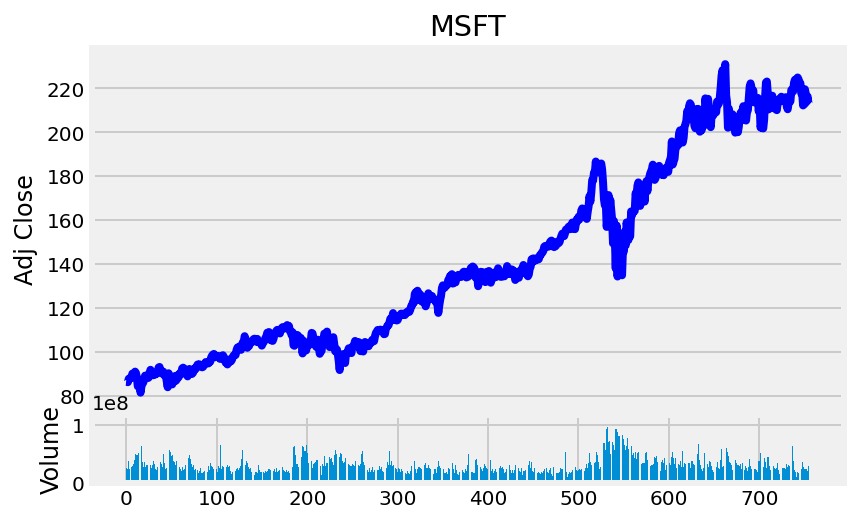

In [40]:
draw_regular_plot(df, stock_name)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


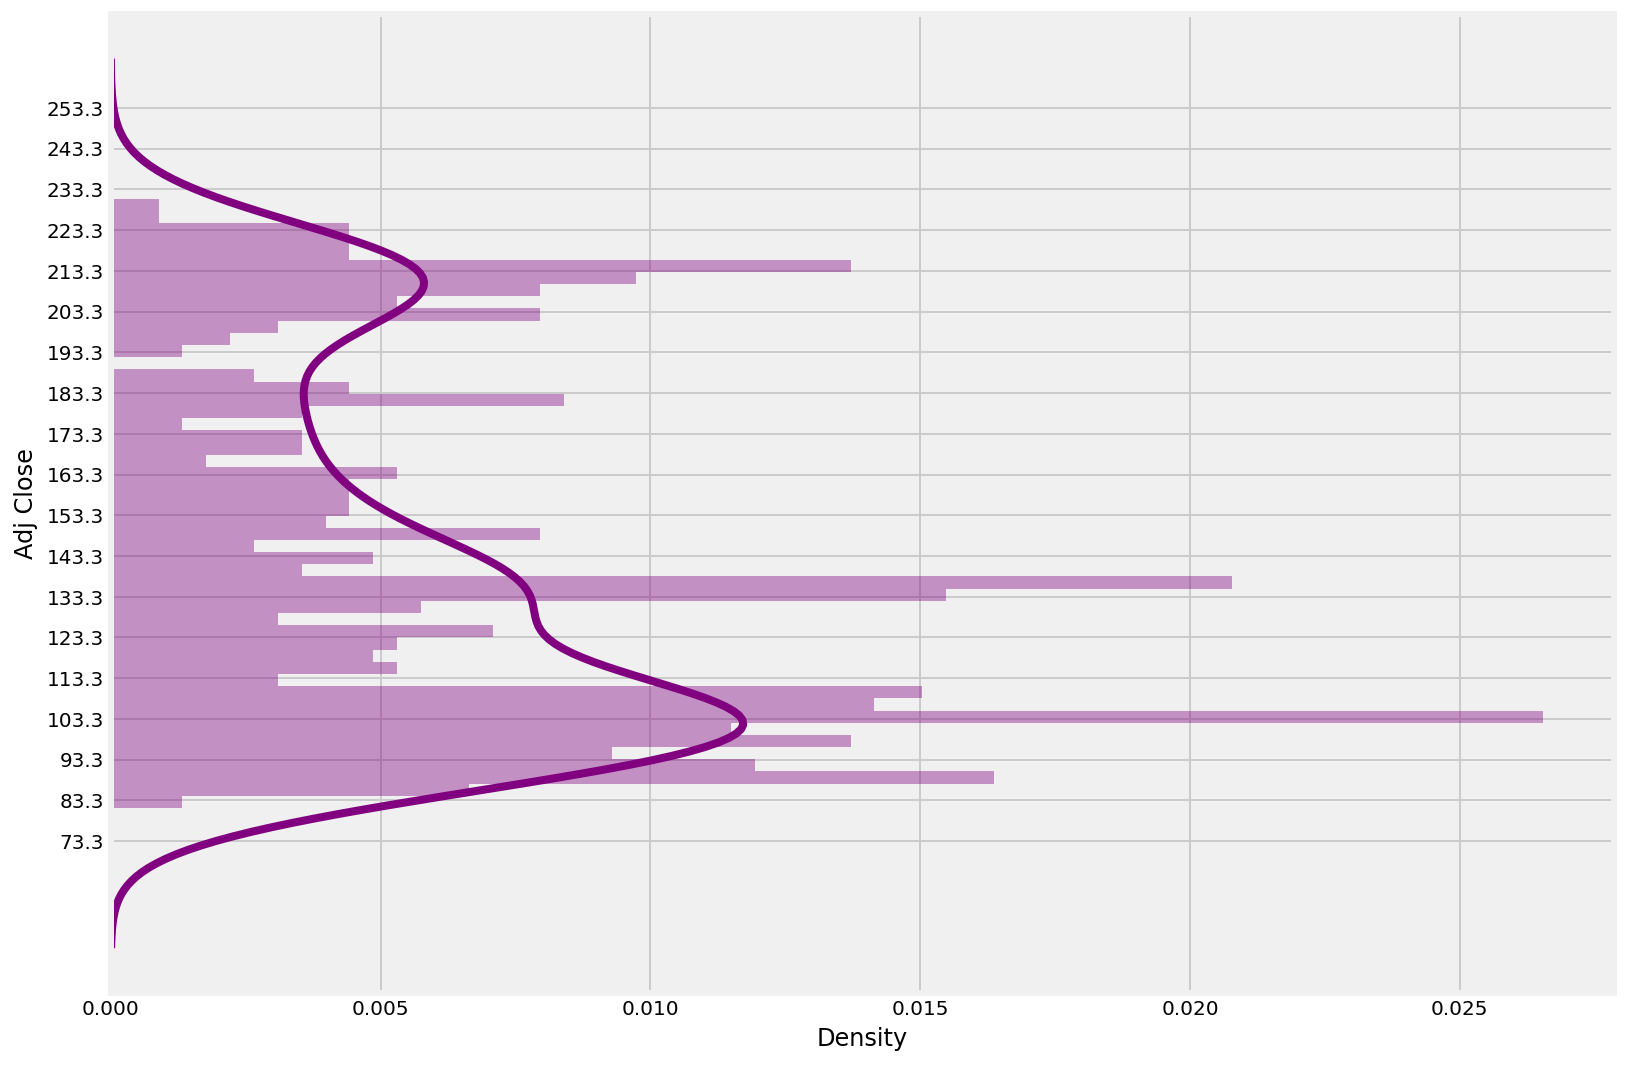

In [41]:
param = {}
param["step"] = 10
draw_density_plot(df, param)

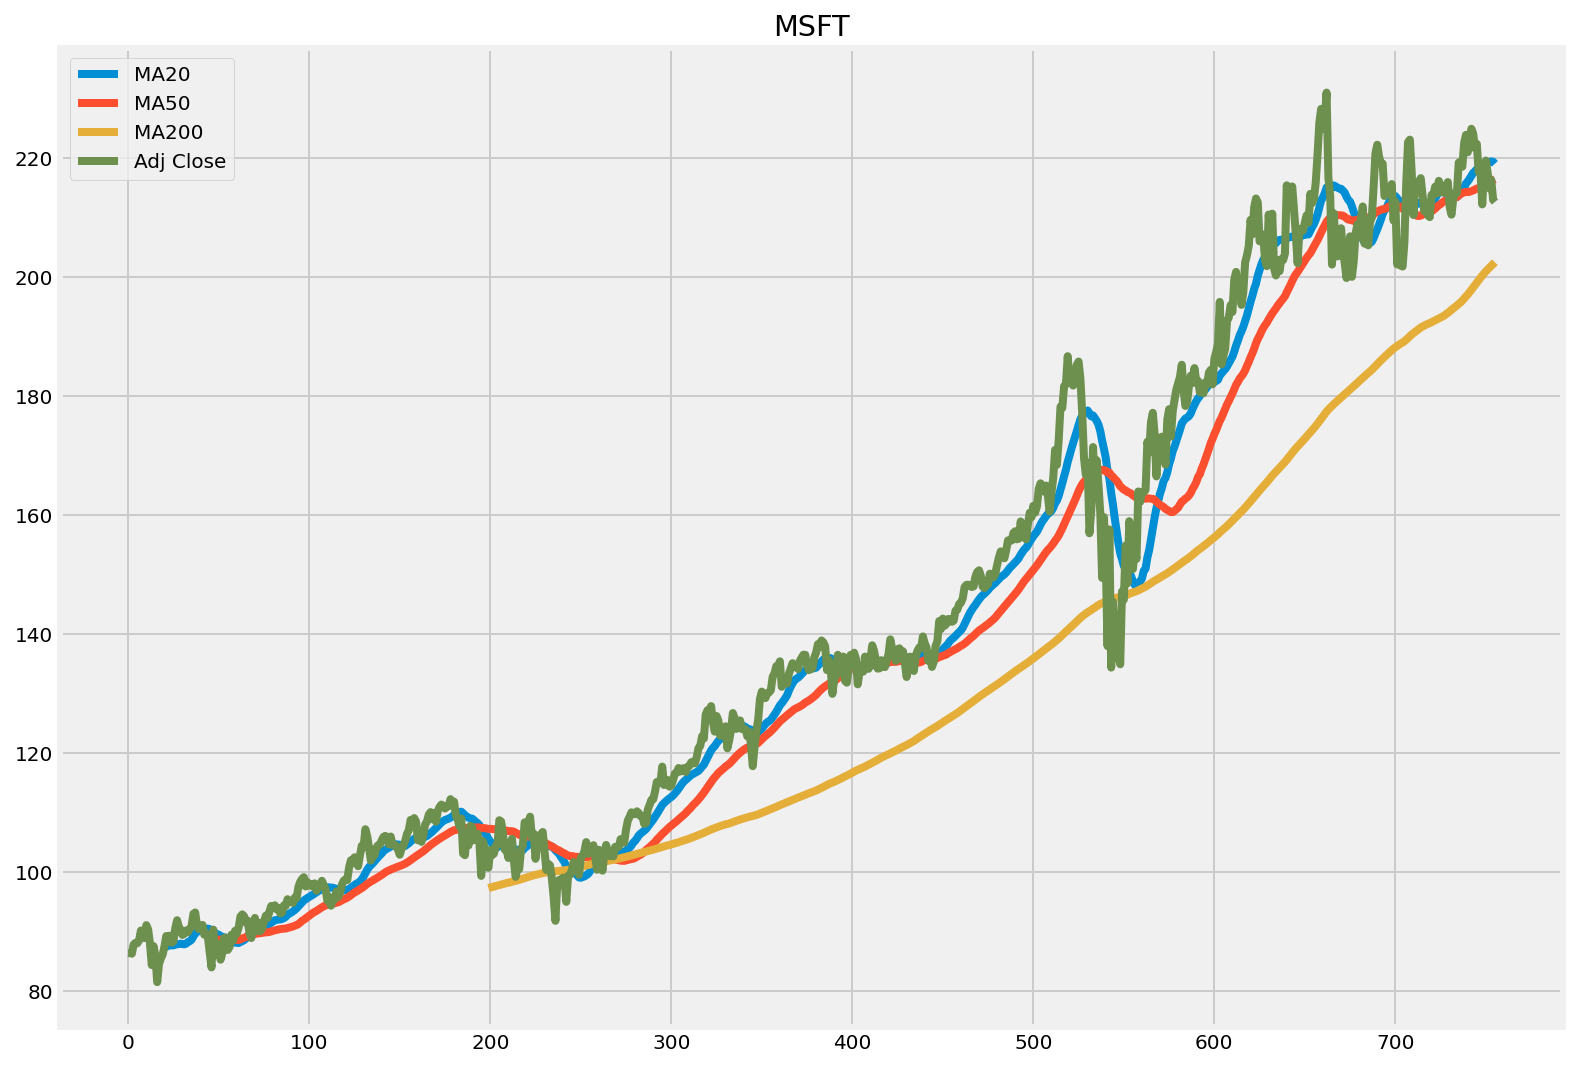

           Date        High         Low  ...        MA20        MA50       MA200
751  2021-01-11  218.910004  216.729996  ...  219.281499  215.611904  201.310884
752  2021-01-12  217.100006  213.320007  ...  219.364999  215.826795  201.642857
753  2021-01-13  216.759995  213.929993  ...  219.471999  216.114769  201.929640
754  2021-01-14  217.460007  212.740005  ...  219.416499  216.339135  202.212325
755  2021-01-15  214.509995  212.029999  ...  219.084998  216.474316  202.520941

[5 rows x 10 columns]


In [42]:
draw_moving_average_plot(df)

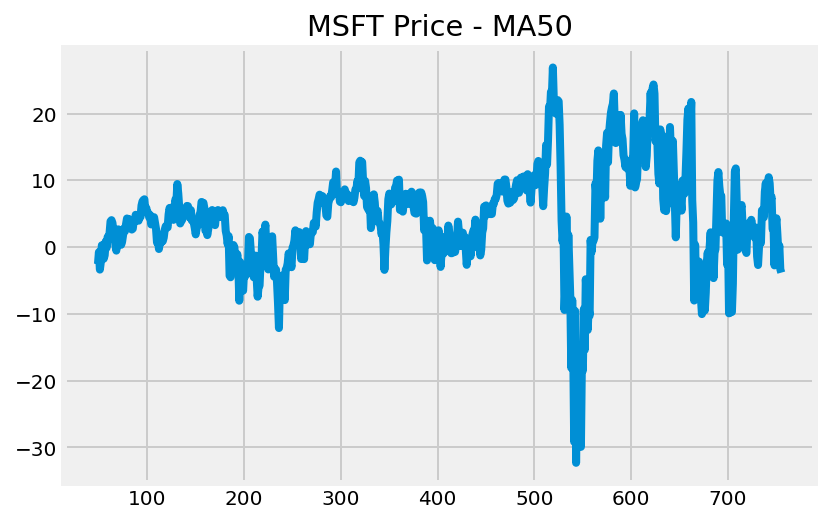

In [57]:
draw_price_to_ma_distance(df, stock_name, {'MA': 50})

# Select stock from stock table

Step 1: choose **stock**

JD , 1.9031526689973481
SPY , 2.8185291811233295
QQQ , 2.9072698499309393


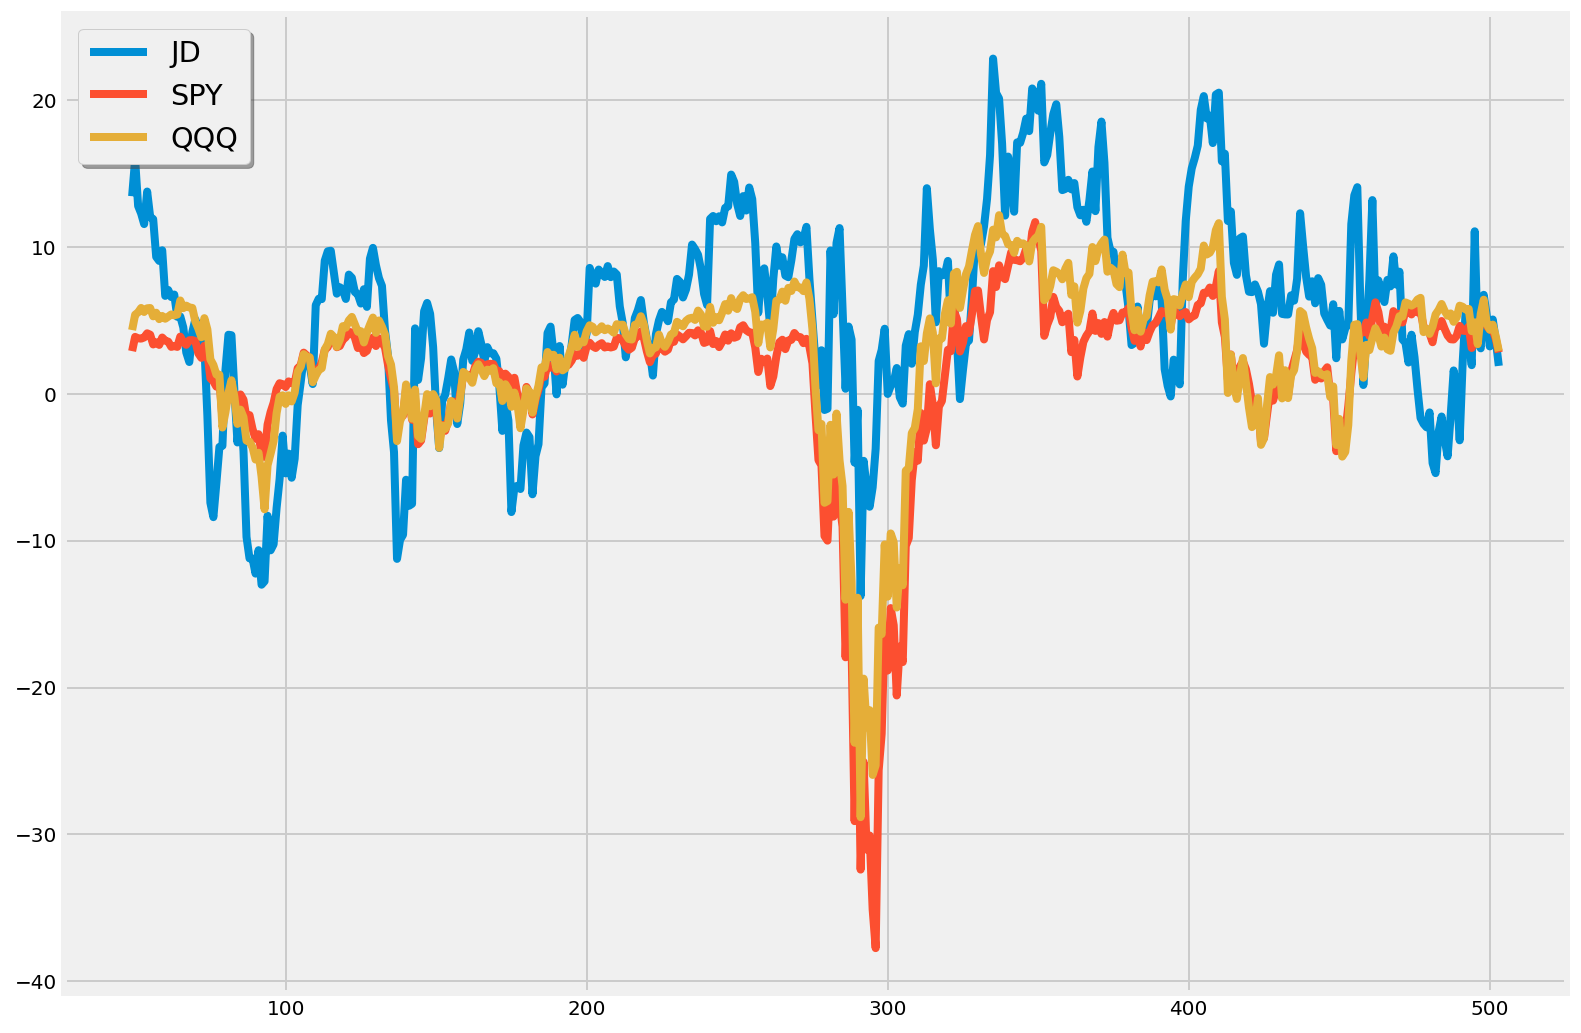

JD , 1.9031526689973481
SPY , 2.8185291811233295
QQQ , 2.9072698499309393


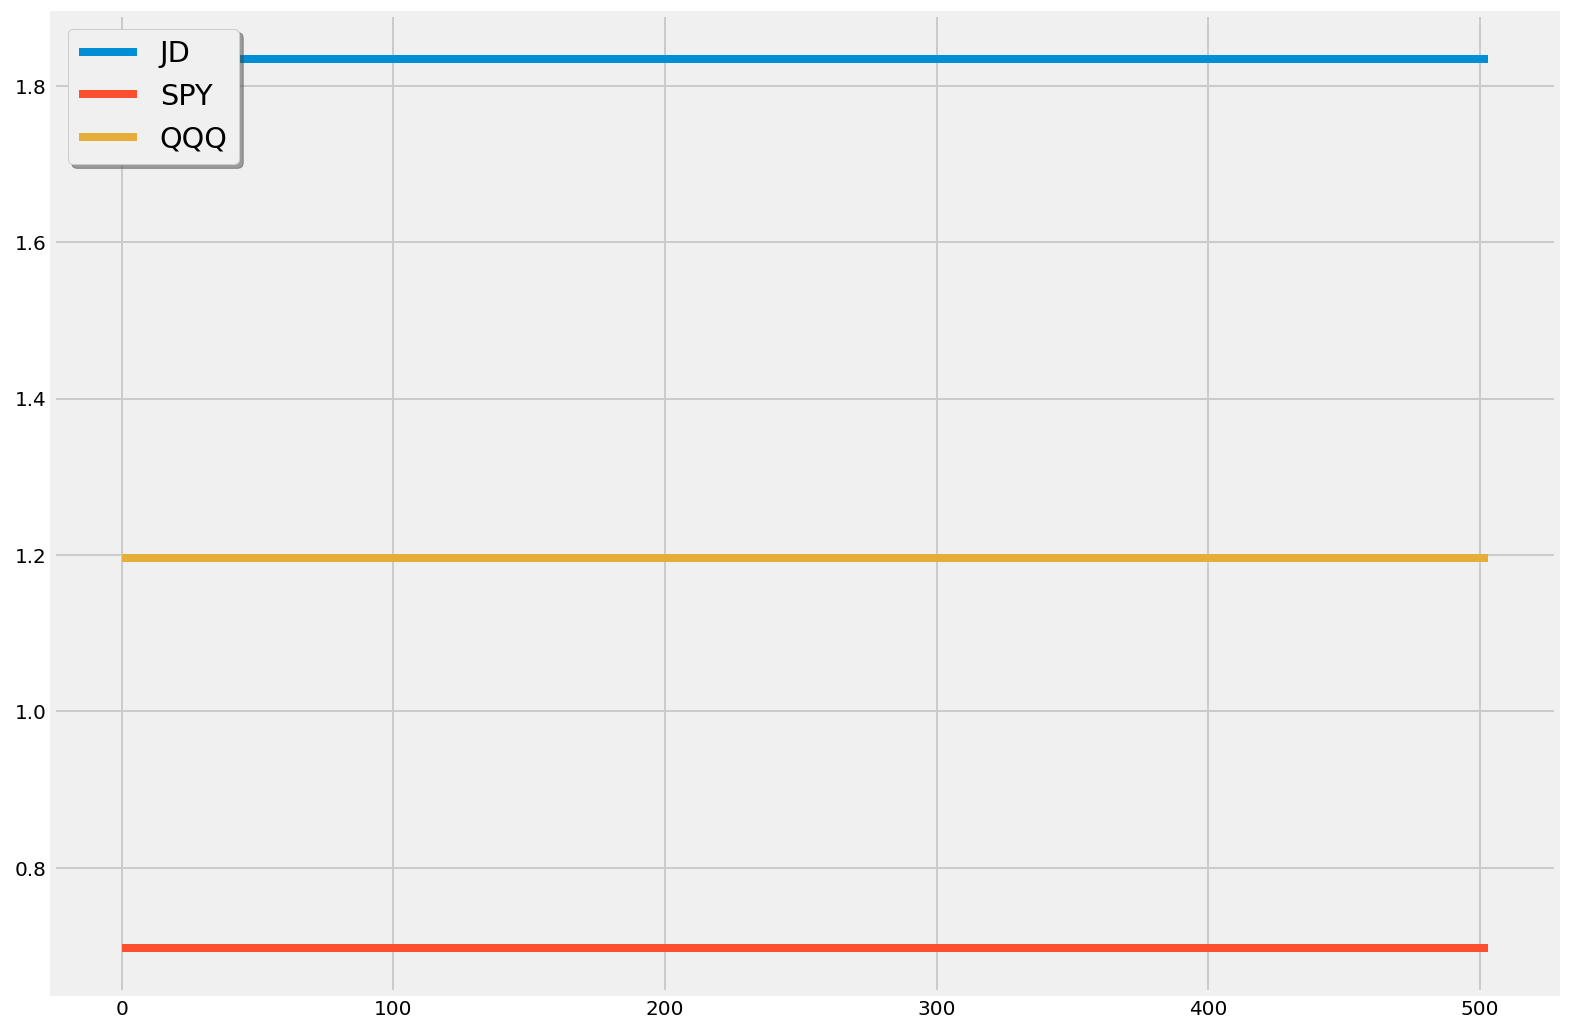

In [126]:
stock_name_list = ['JD', 'SPY', 'QQQ']
end = dt.datetime.now()
start = dt.datetime(end.year - 2, end.month, end.day)
result = {}
for stock_name in stock_name_list:
  df = read_stock_data_to_df(stock_name,start, end)
  df['indicator_1'] =  indicator_1(df)
  df['indicator_2'] = rolling(90).apply(momentum, raw=False)
  result[stock_name] = df

fig, ax = plt.subplots(figsize=(12,9))
for stock_name in stock_name_list:
  ax.plot(result[stock_name]['indicator_1'], label=stock_name)
  print(stock_name, ",",  result[stock_name]['indicator_1'].iloc[-1])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

fig, ax = plt.subplots(figsize=(12,9))
for stock_name in stock_name_list:
  ax.plot(result[stock_name]['indicator_2'], label=stock_name)
  print(stock_name, ",",  result[stock_name]['indicator_1'].iloc[-1])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()


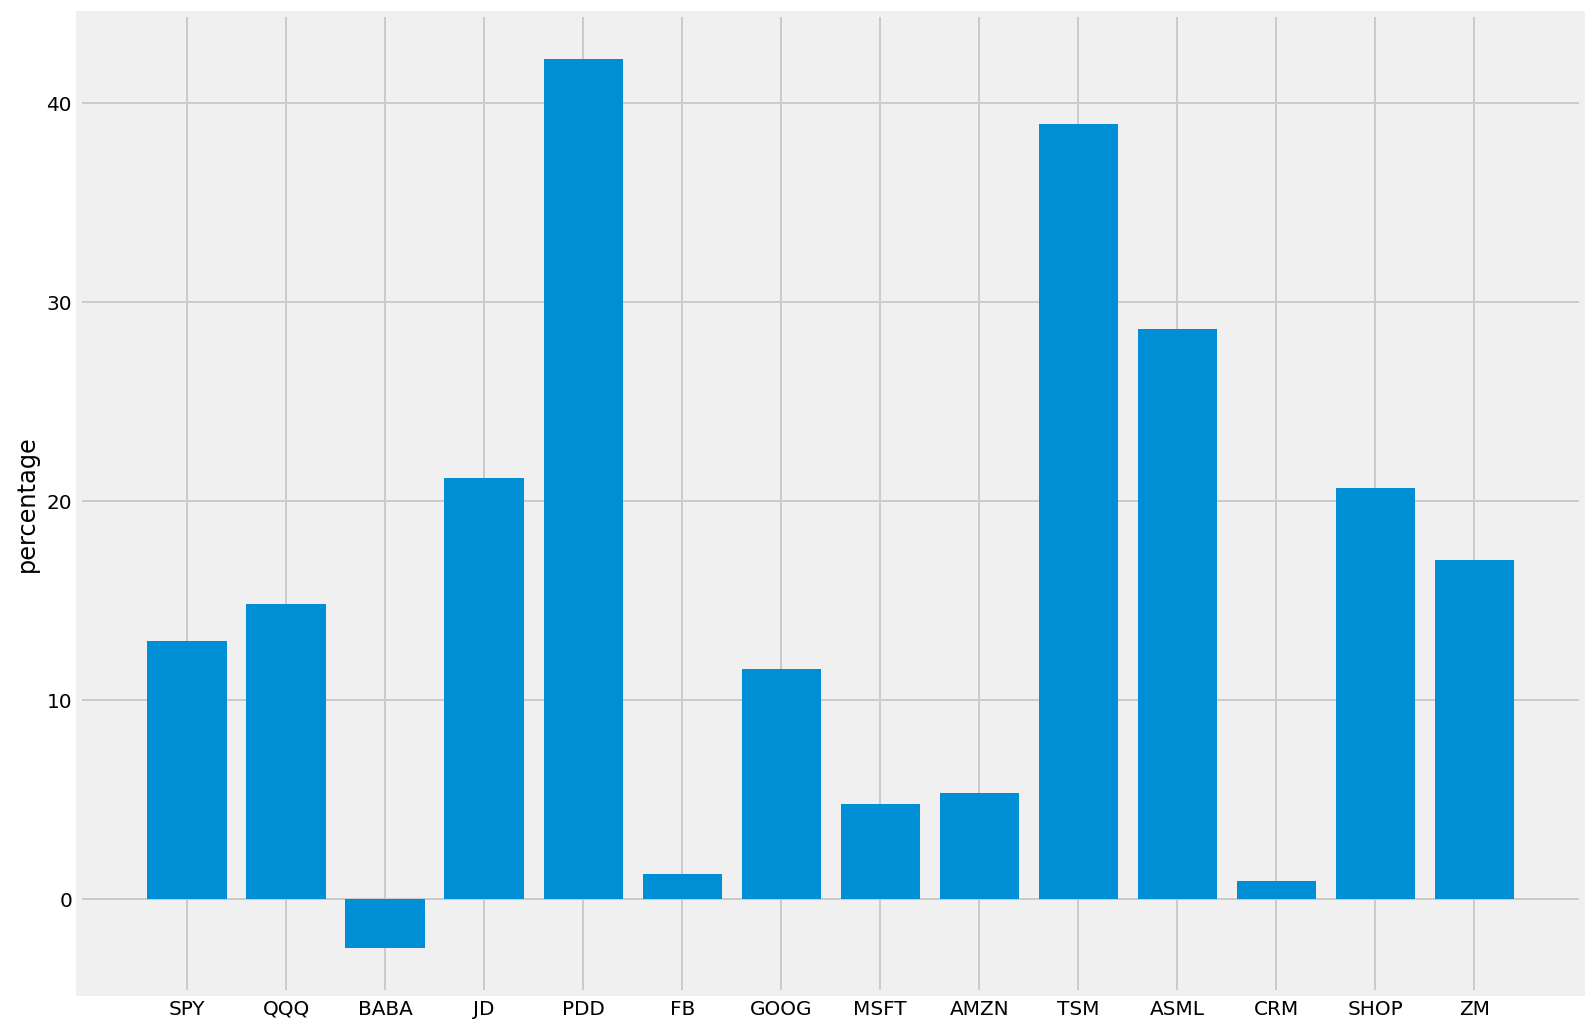

In [121]:
stock_name_list = ['SPY', 'QQQ', 'BABA', 'JD', 'PDD', 'FB', 'GOOG', 'MSFT', 'AMZN','TSM', 'ASML', 'CRM', 'SHOP', 'ZM']
end = dt.datetime.now()
start = dt.datetime(end.year - 2, end.month, end.day)
result = {}
for stock_name in stock_name_list:
  df = read_stock_data_to_df(stock_name,start, end)
  df['indicator_1'] =  (df['Adj Close'] - df['Adj Close'].rolling(200).mean())/df['Adj Close'] * 100
  df['momentum'] = momentum(df)
  result[stock_name] = df

indicator_1 = {}
for stock_name in stock_name_list:
  indicator_1[stock_name] = result[stock_name]['indicator_1'].iloc[-1]
  indicator_2[stock_name] = result[stock_name]['momentum'].iloc[-1]

plt.figure(figsize=(12,9))
plt.bar(range(len(indicator_1)), list(indicator_1.values()), align='center')
plt.xticks(range(len(indicator_1)), list(indicator_1.keys()))
plt.ylabel("percentage")
plt.show()
